In [1]:
%matplotlib inline
import numpy as np
import healpy as hp

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, Math
import zeus
from modules import (init_cosmology, init_sample, PNGModel,
                     Posterior, read_mocks, WindowSHT, 
                     read_weight_mask, WindowRR, read_datacl)

In [2]:
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2  

In [3]:
# --- theory
cosmo = init_cosmology()
z, b, dNdz = init_sample('qsomock')
model = PNGModel(cosmo, has_fnl=True, has_rsd=True)
model.add_tracer(z, b, dNdz, p=1.6)

# --- 'Data'
x, y, invcov, cov = read_mocks('masked', return_cov=True)
weight, mask = read_weight_mask()

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
bins: [  2   4   6   8  10  12  14  16  18  25  49  99 198 398], nmocks: 2000, nbins: 14


/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [4]:
model(np.array([0,  1, 2, 3]), fnl=10.)

will create windows


array([  0.        , 109.6525607 ,  28.74609693,  11.06017239])

In [5]:
xd_af, yd_af = read_datacl('after')
xd_bf, yd_bf = read_datacl('before')

In [6]:
np.sqrt(mask.mean())

0.3539918954499818

In [7]:
# weight = hp.ud_grade(weight, 512)
# mask = hp.ud_grade(mask, 512)
# weight_ = np.ones_like(weight)
# mask_ = np.ones_like(mask)

# rr_file = './rr_window.npy'
# ntot = 107300.0
# npix = 12*256*256

# wr = WindowRR(rr_file, ntot, npix)

el_m = np.arange(3*256)
wd = WindowSHT(weight, mask, el_m, ngauss=3*256)
# wd.read_rr('./rr_window.npy', 107300.0, 12*256*256)

def modelw(ell, fnl):
    cl_null = model(ell, fnl)
    return wd.convolve(ell, cl_null)

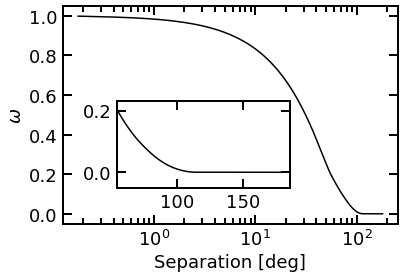

In [8]:
# create figure and add an axes object
fg, ax1 = plt.subplots(figsize=(6, 4))
ax2 = fg.add_axes([0.25, 0.25, 0.4, 0.3])


def add_plot(ax):
    ax.plot(np.arccos(wd.x)*180./np.pi, wd.xi_mask, color='k')
#     ax.plot(np.arccos(wd.x)*180./np.pi, wd.xi_mask, 'C1--')
    
add_plot(ax1)
add_plot(ax2)

ax1.set(xscale='log', xlabel=r'Separation [deg]', ylabel=r'$\omega$')#, title='Window')
#ax1.legend(['SHT', r'SHT(low $\theta$)+RR(large $\theta$)'], 
#           loc='upper right')

# major and minor ticks of the x and y axes
axis_kw = dict(width=2, direction='in', pad=5)
for ax in [ax1, ax2]:
    ax.xaxis.set_tick_params(which='major', size=9, top=True, **axis_kw)
    ax.xaxis.set_tick_params(which='minor', size=6, top=True, **axis_kw)
    ax.yaxis.set_tick_params(which='major', size=9, right=True, **axis_kw)
    ax.yaxis.set_tick_params(which='minor', size=6, right=True, **axis_kw)


ax2.set(ylim=(-0.05, 0.23), xlim=(55, 185))
fg.savefig('basswindow.png', dpi=300, bbox_inches='tight')

will update windows


Text(0, 0.5, '$\\omega$')

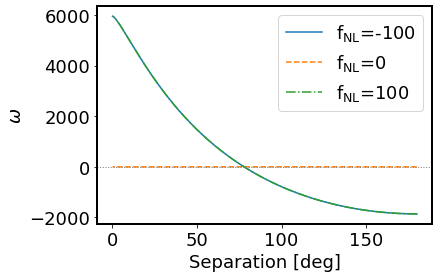

In [9]:
ls = ['-', '--', '-.']

for i, fNL in enumerate([-100, 0, 100]):
    
    cl_null = model(el_m, fNL)
    cl_null[0] = 0
    plt.plot(np.rad2deg(np.arccos(wd.x)), 
             wd.cl2xi(el_m, cl_null), 
             label=r'f$_{\rm NL}$=%d'%fNL, ls=ls[i])
    
plt.axhline(0.0, ls=':', lw=1, color='grey')    
# plt.ylim(-0.0001, 0.0001)    
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlabel('Separation [deg]')
plt.ylabel(r'$\omega$')
# plt.savefig('omega_fnl.png', dpi=300, bbox_inches='tight')

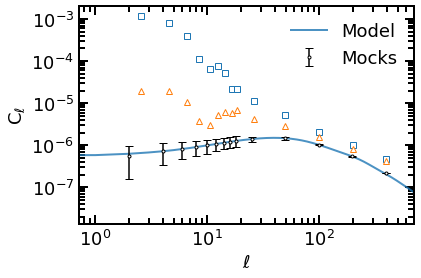

In [10]:
# plot
el_m = np.arange(3*256)


fig, ax = plt.subplots()


ax.errorbar(x, y, yerr=np.diag(cov)**0.5, 
             ls='none', color='k', marker='o', mfc='w', capsize=4, 
             label='Mocks', zorder=10, markersize=3)

ax.plot(xd_bf, yd_bf, ls='None', marker='s', mfc='w')
ax.plot(xd_af, yd_af, ls='None', marker='^', mfc='w')



# ax.plot(el_m, model(el_m, 0),     'k-',  alpha=0.8, lw=0.5)
# ax.plot(el_m, model(el_m, 20.),  'k--', alpha=0.8, lw=0.5)
# ax.plot(el_m, model(el_m, -20.), 'k--', alpha=0.8, lw=0.5)

# plt.plot(el_m, modelw(el_m, 0,),     'C0-',  alpha=0.8, lw=)
# plt.plot(el_m, modelw(el_m, 100., ), 'C0--', alpha=0.8, lw=0.8)
# plt.plot(el_m, modelw(el_m, -100.,), 'C0--', alpha=0.8, lw=0.8)

ax.plot(el_m, modelw(el_m, 0,),    'C0-',  alpha=0.8, lw=2, label='Model')
# ax.plot(el_m, modelw(el_m, 20.), 'C0--', alpha=0.8, lw=1)
# ax.plot(el_m, modelw(el_m, -20.), 'C0--', alpha=0.8, lw=1)

# plt.plot(el_m, modelw(el_m, 0, [0, 1]), 'C2-', alpha=0.8)
# plt.plot(el_m, modelw(el_m, 100., [0, 1]), 'C2--', alpha=0.8, lw=0.8)
# plt.plot(el_m, modelw(el_m, -100., [0, 1]), 'C2--', alpha=0.8, lw=0.8)


axis_kw = dict(width=2, direction='in', pad=5)
ax.xaxis.set_tick_params(which='major', size=9, top=True, **axis_kw)
ax.xaxis.set_tick_params(which='minor', size=6, top=True, **axis_kw)
ax.yaxis.set_tick_params(which='major', size=9, right=True, **axis_kw)
ax.yaxis.set_tick_params(which='minor', size=6, right=True, **axis_kw)
    
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((5.0e-8, 9.e-5))
ax.legend(frameon=False)
ax.set_xlim(xmax=700)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel('C$_{\ell}$')
fig.savefig('bassmodel.png', dpi=300, bbox_inches='tight', facecolor='w')

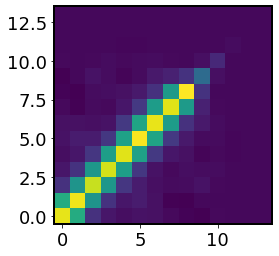

In [9]:
plt.imshow(cov, origin='lower')

In [12]:
wd = WindowSHT(weight, mask, x)
ell_ = np.arange(768)

def modelw(ell, fnl):
    cl_null = model(ell_, fnl)
    return wd.convolve(ell_, cl_null)

lg = Posterior(modelw)

In [13]:
for fNL in [-999, -500, -100, -10, 0, 10, 100, 500, 999]:
    print(fNL, lg.logpost(fNL, y, invcov, x))

-999 -28017132.671119623
-500 -1747622.0276246534
-100 -2678.6896703493853
-10 -4.274916677958705
0 -4.064843248916713
10 -4.7945085298888
100 -3027.030321044985
500 -1790957.0317479686
999 -28362721.999468833


In [8]:
np.random.seed(42)

ndim = 1       # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10  # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 1000  # Number of steps/iterations.

start = 10. * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.
print(f'initial guess: {start}')

sampler = zeus.EnsembleSampler(nwalkers, ndim, lg.logpost, args=[y, invcov, x], maxiter=100000)
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...


initial guess: [[ 4.96714153]
 [-1.38264301]
 [ 6.47688538]
 [15.23029856]
 [-2.34153375]
 [-2.34136957]
 [15.79212816]
 [ 7.67434729]
 [-4.69474386]
 [ 5.42560044]]


Sampling progress :   3%|▎         | 33/1000 [12:03<6:49:12, 25.39s/it]

KeyboardInterrupt: 

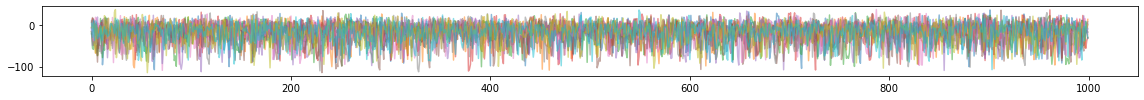

In [7]:
plt.figure(figsize=(16, 1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# flatten the chains, thin them by a factor of 15, 
# and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=20, thin=5)

In [9]:
np.save('chains_window.npy', chain)  # 

In [6]:
chainw = np.load('chains_qsomock_masked.npy', allow_pickle=True)
chain = np.load('chains.npy', allow_pickle=True)

In [7]:
bins = np.arange(-1000, 1000., 3.8*np.std(chain)/(chain.size)**(1./3)) #
bins[:10]

array([-1000.        ,  -992.43724517,  -984.87449034,  -977.31173551,
        -969.74898068,  -962.18622585,  -954.62347101,  -947.06071618,
        -939.49796135,  -931.93520652])

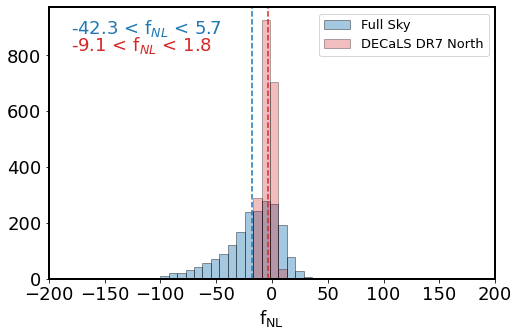

In [8]:
fg, ax = plt.subplots(figsize=(8, 5))

colors = ['C0', 'C3']
names = ['Full Sky', 'DECaLS DR7 North']

for i, chain_ in enumerate([chain, chainw]):
    
    _= ax.hist(chain_,
                bins=bins, alpha=0.4-i*0.1, edgecolor='k', color=colors[i],
              label=names[i])
    ax.axvline(np.mean(chain_), ls='--', color=colors[i])
    fmin, fmax = np.percentile(chain_, [15.7, 84.3])
    ax.text(0.05, 0.9-i*0.06, fr"{fmin:.1f} < f$_{'{NL}'}$ < {fmax:.1f}", 
            transform=ax.transAxes, color=colors[i])

ax.set(xlabel=r'f$_{\rm NL}$', xlim=(-200, 200))
ax.legend(fontsize=13)
# plt.savefig('fnl.png', dpi=300, bbox_inches='tight')

In [14]:
np.mean(chain)

-17.56812161234904

In [15]:
np.percentile(chain, [15.7, 84.3])

array([-42.30893137,   5.66338158])